# Intro to Model and Data Drift

When a model is put into production, it moves from a static environment where the relationship between the input & output doesn’t change to a live environment where the relationship between the input & output does change. The changing relationship causes the model to start losing predictive power. This loss in predictive power is called model drift.


In general, there are two reasons why drift can occur in machine learning models.

1. The first one is when an external event mixes up the data: customers’ preferences suddenly change due to the pandemic, or a competitor launches a new product or service. If this has happened, an update or retraining is necessary for your model to keep producing accurate predictions.
2. The other reason is when there is something wrong with the data integrity. For example, the model swaps two values like the height of a person and their age, or a website suddenly accepts blank fields due to a bug.

Both of these reasons are important to monitor and detect. But let's focus on the first one, the external events that change the data.

An example:

You've built a model that tries to predict how much a person will spend in an online webshop, using the age and the gender of a person. The training data set mostly consists of females, with the average age of all customers being 35. The model learns that mostly older people and women buy something more often. After monitoring my model’s predictive performance, you notice that it’s starting to decrease… But why? 

After doing some research you discovered that the webshop now has younger customers: the average age has dropped from 35 years to 25 years. Furthermore, the live data shows that currently not the women, but the men!

So, the original relationship between the features that the model has learned from the original training data set, isn’t valid anymore on the real-time incoming data. Which causes the model to lose its predictive power. This loss in predictive power is called model drift and the change in the data is called data drift.

Let's have a look on the NY taxi data set.

In [1]:
import os
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt
import mlflow

load_dotenv()

True

Let's start by loading the data sets. The first one is the dataset we train the model on:


In [2]:
year = 2021
month = 1
color = "green"

df_21_1 = pd.read_parquet(f"./data/{color}_tripdata_{year}-{month:02d}.parquet")


The second one is the dataset we compare to the first one.

In [3]:
year = 2022
month = 2
color = "green"

if not os.path.exists(f"./data/{color}_tripdata_{year}-{month:02d}.parquet"):
    os.system(f"wget -P ./data https://d37ci6vzurychx.cloudfront.net/trip-data/{color}_tripdata_{year}-{month:02d}.parquet")

df_22_2 = pd.read_parquet(f"./data/{color}_tripdata_{year}-{month:02d}.parquet")

--2023-07-19 11:25:09--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 143.204.101.58, 143.204.101.20, 143.204.101.175, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|143.204.101.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1428262 (1,4M) [binary/octet-stream]
Saving to: ‘./data/green_tripdata_2022-02.parquet’

     0K .......... .......... .......... .......... ..........  3%  918K 1s
    50K .......... .......... .......... .......... ..........  7% 1,44M 1s
   100K .......... .......... .......... .......... .......... 10% 5,08M 1s
   150K .......... .......... .......... .......... .......... 14% 2,93M 1s
   200K .......... .......... .......... .......... .......... 17% 9,72M 1s
   250K .......... .......... .......... .......... .......... 21% 2,61M 1s
   300K .......... .......... .......... .......... ......

We will only look at the features we trained the model on:

In [4]:
features = ["PULocationID", "DOLocationID", "trip_distance", "passenger_count", "fare_amount", "total_amount"]
target = 'duration'

In [5]:
def calculate_trip_duration_in_minutes(df):
    df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).dt.total_seconds() / 60
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 8)]
    df = df[features + [target]]
    return df

In [6]:
df_21_1 = calculate_trip_duration_in_minutes(df_21_1)
df_22_2 = calculate_trip_duration_in_minutes(df_22_2)
df_22_2 = df_22_2.iloc[:len(df_21_1)]

### Now let's compare the data

In [7]:
df_21_1.describe()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,total_amount,duration
count,38065.000000,38065.000000,38065.000000,38065.00000,38065.000000,38065.000000,38065.000000
mean,96.493498,133.189833,9.633975,1.19958,13.379229,16.682105,13.694301
std,63.304463,77.830987,1251.393768,0.76102,11.961410,13.420166,10.404338
min,3.000000,1.000000,0.000000,1.00000,-280.000000,-280.300000,1.000000
25%,43.000000,69.000000,1.100000,1.00000,6.500000,8.800000,6.650000
50%,75.000000,132.000000,1.860000,1.00000,9.500000,12.560000,10.716667
75%,124.000000,210.000000,3.550000,1.00000,15.500000,19.550000,17.233333
max,265.000000,265.000000,244152.010000,6.00000,280.000000,280.300000,59.983333


In [8]:
df_22_2.describe()

,PULocationID,DOLocationID,trip_distance,passenger_count,fare_amount,total_amount,duration
count,38065.000000,38065.000000,38065.000000,38065.000000,38065.000000,38065.000000,38065.000000
mean,96.312807,135.542546,2.599572,1.264101,12.708339,16.284270,14.461234
std,60.365329,76.672934,2.495192,0.880764,9.061809,10.771056,9.820250
min,3.000000,1.000000,0.000000,1.000000,-75.000000,-75.300000,1.000000
25%,65.000000,74.000000,1.110000,1.000000,7.000000,9.350000,7.616667
50%,75.000000,138.000000,1.810000,1.000000,10.000000,13.500000,11.916667
75%,129.000000,213.000000,3.200000,1.000000,15.200000,19.800000,18.450000
max,265.000000,265.000000,36.500000,6.000000,210.000000,210.300000,59.950000


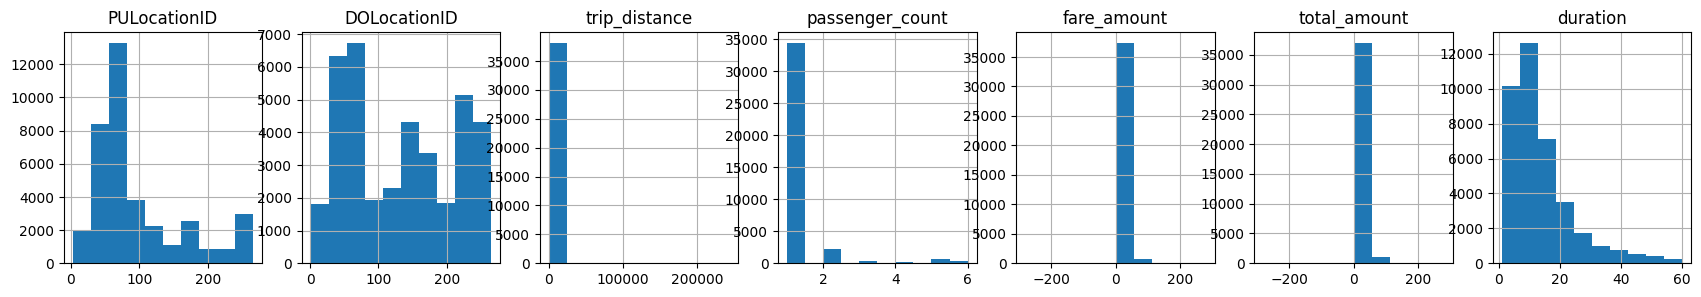

In [9]:
fig, ax = plt.subplots(1, len(df_21_1.columns), figsize=(3*len(df_21_1.columns), 3))
for i, var in enumerate(df_21_1):
    df_21_1[var].hist(ax=ax[i])
    ax[i].set_title(var)
plt.show()

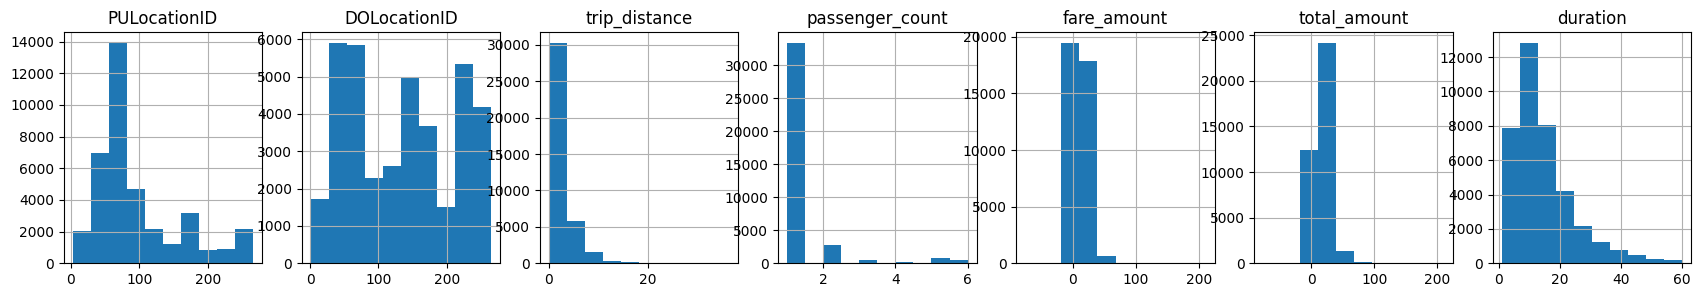

In [10]:
fig, ax = plt.subplots(1, len(df_22_2.columns), figsize=(3*len(df_22_2.columns), 3))
for i, var in enumerate(df_22_2):
    df_22_2[var].hist(ax=ax[i])
    ax[i].set_title(var)
plt.show()

We see small changes in nearly all features. But we can also calculate the difference between the two data sets with the Wasserstein distance for numerical features and the Jensen-Shannon distance for categorical features. Both are metrics that calculates the distance between two probability distributions. The lower the value, the more similar the two distributions are.

Let's calculate the Wasserstein distance between the features of the two data sets:

In [11]:
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
import numpy as np

def drift_wasserstein_test(var_train: pd.Series, var_test: pd.Series):
    return wasserstein_distance(var_train, var_test)

def drift_jensenshannon_test(var_train: pd.Series, var_test: pd.Series):
    return jensenshannon(var_train, var_test)

In [13]:
df_drift = pd.DataFrame(columns=["feature", "distance"])

cat_features = ["PULocationID", "DOLocationID"]
num_features = ["trip_distance", "passenger_count", "fare_amount", "total_amount"]

for feature in num_features:
    df_drift = pd.concat(
        [df_drift, 
         pd.DataFrame(
            [{"feature": feature, 
            "wasserstein_distance": drift_wasserstein_test(df_21_1[feature],
                                                           df_22_2[feature])}])],
            ignore_index=True
        )

for feature in cat_features:
    df_drift = pd.concat(
        [df_drift, 
         pd.DataFrame(
            [{"feature": feature, 
            "wasserstein_distance": drift_jensenshannon_test(df_21_1[feature],
                                                           df_22_2[feature])}])],
            ignore_index=True
        )

There are more tests to detect drift, but this is a good start. If you want to learn more about drift detection, check out this [article](https://www.evidentlyai.com/blog/data-drift-detection-large-datasets). For both Wasserstein and Jensen-Shannon distance there is a threshold value. If the distance is higher than the threshold, we can say that there is drift. For both the threshold is normally at 0.1. Let's check if there is drift in the data:

In [14]:
df_drift

,feature,distance,wasserstein_distance
0,trip_distance,NaN,7.043676
1,passenger_count,NaN,0.064521
2,fare_amount,NaN,1.345826
3,total_amount,NaN,1.469330
4,PULocationID,NaN,0.300265
5,DOLocationID,NaN,0.302452


So it seems we can confirm what we saw in the histograms. There is drift in nearly all features except tje passenger count. This method we can also use to detect drift in the target variable. Let's have a look at the target variable:

In [15]:
drift_wasserstein_test(df_21_1[target],df_22_2[target])

1.0568050264897764

So we also have a drift in our target variable.

Of course you can also use the drift detection methods to detect drift in the prediction of our data. Let's load the model and do predictions on the two data sets:

In [16]:
MLFLOW_TRACKING_URI=os.getenv("MLFLOW_TRACKING_URI")
# Set up the connection to MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# Setup the MLflow experiment 
mlflow.set_experiment("green-taxi-monitoring")

SA_KEY=os.getenv("SA_KEY")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SA_KEY

In [17]:
def load_model(model_name):
    stage = "Production"
    model_uri = f"models:/{model_name}/{stage}"
    model = mlflow.pyfunc.load_model(model_uri)
    return model

model_name = "green-taxi-ride-duration"

loaded_model = load_model(model_name)

2023/07/19 11:33:29 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.2, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [18]:
model_name = "green-taxi-ride-duration"

loaded_model = load_model(model_name)

2023/07/19 11:33:33 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.2, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [19]:
df_21_1["prediction"] = loaded_model.predict(df_21_1[features])

In [20]:
df_22_2["prediction"] = loaded_model.predict(df_22_2[features])

And now we can calculate the drift in the predictions:

In [21]:
drift_wasserstein_test(df_21_1["prediction"],df_22_2["prediction"])

1.0000542799236964

And also here we can see the drift. All this drifts lead to a loss of predictive power. So we need to retrain our model. But how often do we need to retrain our model? This is a difficult question to answer. It depends on the problem you are trying to solve. If you are trying to predict the stock market, you probably need to retrain your model every day. But if you are trying to predict the price of a house, you probably need to retrain your model every month. But in general, you need to retrain your model when the drift is higher than the threshold you set.

In the next notebook we will have a look at how we can do this in a more automated way.